In [1]:
import json
import pickle
import numpy as np
import pandas as pd
import os.path as op
import itertools as it
from utilities import files
from mne import read_epochs
import matplotlib.pylab as plt
from joblib import Parallel, delayed
from tqdm.notebook import trange, tqdm
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from scipy.ndimage import gaussian_filter, gaussian_filter1d
from extra.tools import many_is_in, cat, shuffle_array, shuffle_array_range, consecutive_margin_ix, dump_the_dict

In [2]:
waveform_subset_path = "/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/waveforms_clean_subset_fit.npy"
scaler_path = "/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/scaler_MEG.pkl"
PCA_path = "/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/pca_solution_MEG.pkl"
dataset = "/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/sub_metrics.pkl"
visual_epoch_file = "/home/mszul/datasets/explicit_implicit_beta/derivatives/processed/sub-145/sub-145-002-visual-epo.fif"
motor_epoch_file = "/home/mszul/datasets/explicit_implicit_beta/derivatives/processed/sub-145/sub-145-002-motor-epo.fif"
PC_score_in_time_file = "/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/PC_score_in_time.pkl"
burst_features_file = "/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/burst_features.csv"
waveform_array_file = "/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/all_waveforms.npy"

In [3]:
visual_epoch = read_epochs(visual_epoch_file, verbose=False)
motor_epoch = read_epochs(motor_epoch_file, verbose=False)
visual_epoch_times = visual_epoch.times
motor_epoch_times = motor_epoch.times
del visual_epoch
del motor_epoch

In [4]:
buffer = 0.125
bin_width=0.05
baseline_range = [-0.5, -0.25]


visual_time_bins = np.arange(visual_epoch_times[0] + buffer, visual_epoch_times[-1] - buffer, bin_width)
motor_time_bins = np.arange(motor_epoch_times[0] + buffer, motor_epoch_times[-1] - buffer, bin_width)

visual_bin_ranges = list(zip(visual_time_bins[:-1], visual_time_bins[1:]))
motor_bin_ranges = list(zip(motor_time_bins[:-1], motor_time_bins[1:]))
vis_time_plot = visual_time_bins[:-1]
mot_time_plot = motor_time_bins[:-1]

In [5]:
scaler_meg = pickle.load(open(scaler_path, "rb"))
PCA_saved = pickle.load(open(PCA_path, "rb"))
shuffled_var_exp_ratio_file = "/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/shuffled_var_exp_ratio.npy"
pca_vars = np.load(shuffled_var_exp_ratio_file)
shuffling_results = np.mean(np.vstack([i <= PCA_saved.explained_variance_ratio_ for i in pca_vars]), axis=0)
PC_score_in_time = pickle.load(open(PC_score_in_time_file, "rb"))

In [6]:
waveform_array = np.load(waveform_array_file)
burst_features = pd.read_csv(burst_features_file)

In [6]:
PC_mean_score_in_time = {
       ep: {
          "PC_{}".format(pc+1) : [] for pc in range(20)
       } for ep in ["mot", "vis"] 
    }

for sub in PC_score_in_time.keys():
    for ep in PC_score_in_time[sub].keys():
        for pc_key in PC_score_in_time[sub][ep].keys():
            data = np.vstack(PC_score_in_time[sub][ep][pc_key])
            data = np.nanmean(data, axis=0)
            PC_mean_score_in_time[ep][pc_key].append(data)

In [7]:
PC_mean_variance_of_score_in_time = {ep: [] for ep in ["mot", "vis"]}

for ep in PC_mean_score_in_time.keys():
    for pc_ix in PC_mean_score_in_time[ep].keys():
        data = np.vstack(PC_mean_score_in_time[ep][pc_ix])
        data = np.var(np.mean(data, axis=0))
        PC_mean_variance_of_score_in_time[ep].append(data)

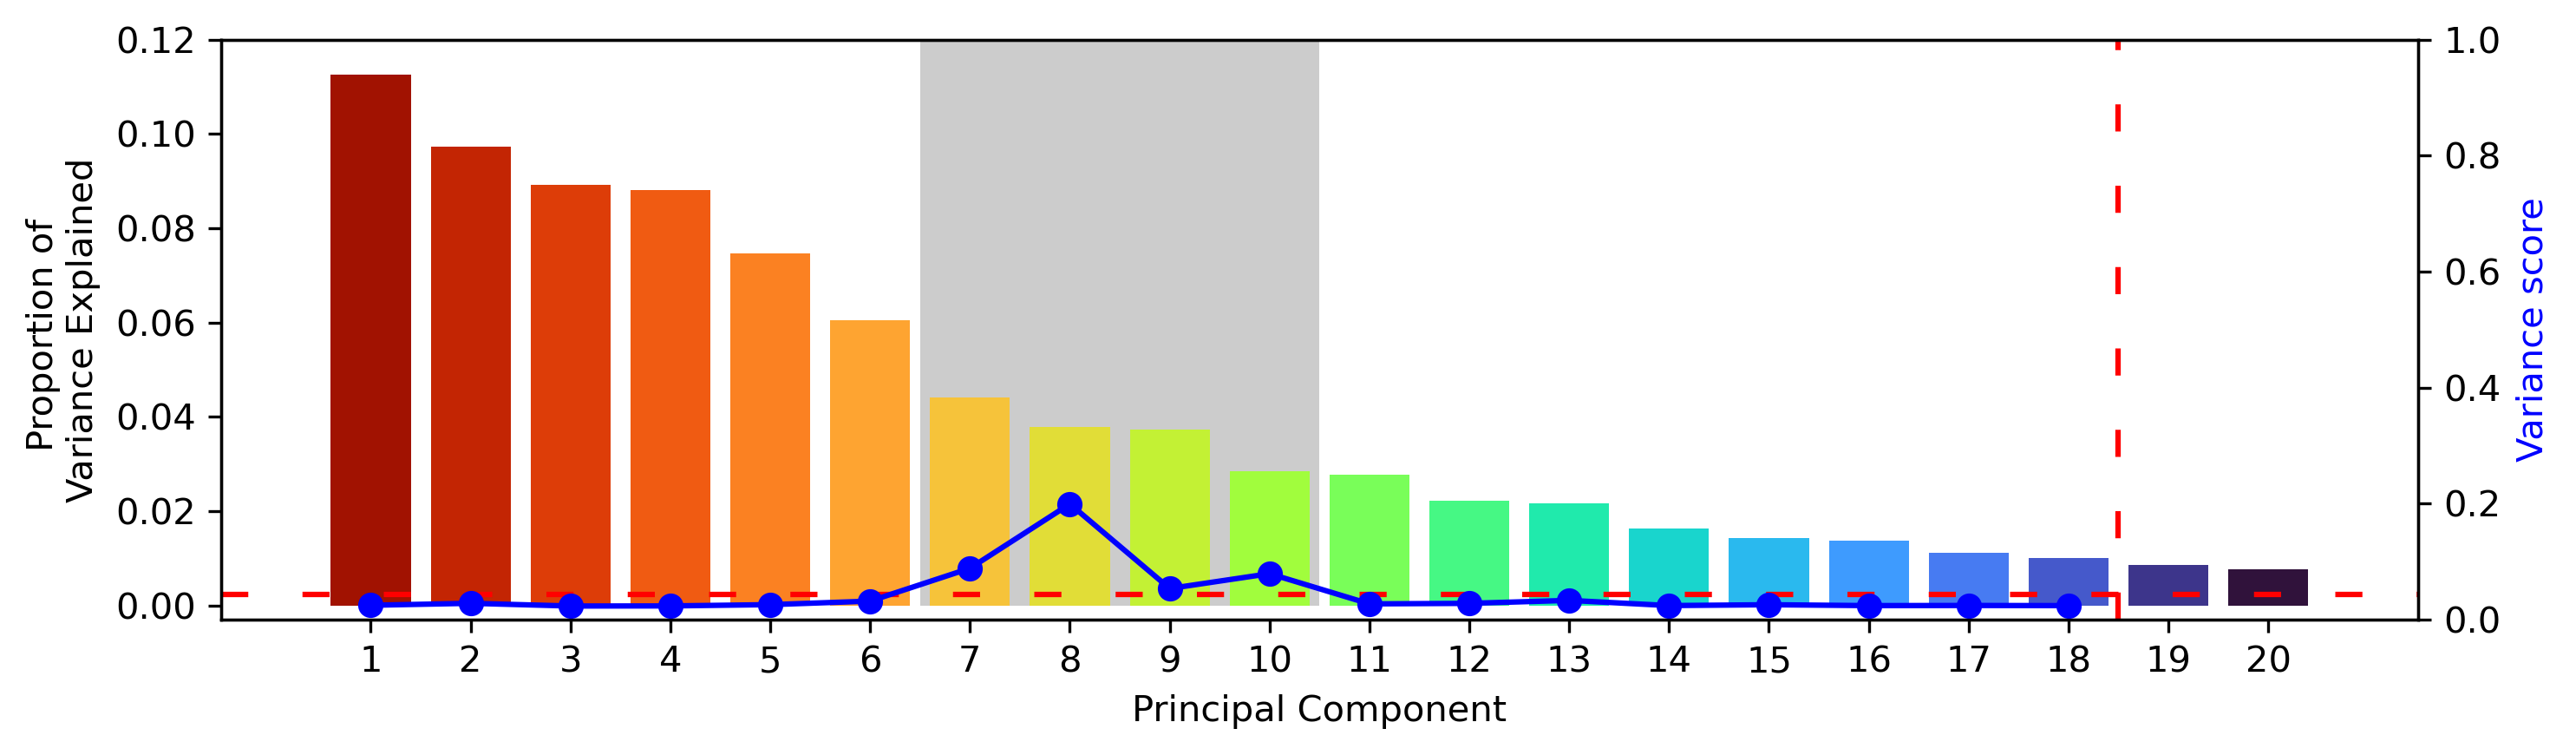

In [11]:
f, ax = plt.subplots(1, 1, figsize=(10,3), dpi=300, facecolor="white", constrained_layout=True)
PC_var_exp = PCA_saved.explained_variance_ratio_
PC_r = np.arange(PC_var_exp.shape[0]) + 1
var_comps = [6, 7, 8, 9]

var_results = np.zeros(PC_r.shape)
for i in range(PC_r.shape[0]):
    if many_is_in(var_comps, [i]):
        var_results[i] = 1

bar = ax.bar(PC_r, var_results, lw=0.2, color="black", alpha=0.2, width=1)
bar = ax.bar(PC_r, PC_var_exp, lw=0.2)
cm = plt.cm.get_cmap("turbo_r")
for i in PC_r:
    plt.setp(bar[i-1],"facecolor", cm(i/20))

PC_RES_SUB = np.array(PC_mean_variance_of_score_in_time["mot"])[:-2] - np.array(PC_mean_variance_of_score_in_time["vis"])[:-2]
ax.scatter(PC_r[:-2], PC_RES_SUB, color="blue", zorder=10)
ax.plot(PC_r[:-2], PC_RES_SUB, color="blue", zorder=10)


ax.set_xlabel("Principal Component")
ax.set_ylabel("Proportion of \nVariance Explained")
ax.set_xticks(PC_r)
ax.set_ylim(-0.003, 0.12)
ax.axvline(18.5, color="red", linestyle=(0, (5, 10)))

ax.axhline(np.mean(PC_RES_SUB), color="red", linestyle=(0, (5, 10)))

ax2 = ax.twinx()
ax2.set_ylabel("Variance score", color="blue")
plt.tight_layout();


# plt.savefig("/scratch/BURST_PAPER/FIGURE_4_PC_var_exp.svg")

In [12]:
np.mean(PC_RES_SUB)

0.0024221545041829746

In [10]:
mean_waveform = (np.mean(waveform_array, axis=0))

In [11]:
waveform_time = np.linspace(-.13, .13, num=156)

In [12]:
pc_keys = ["PC_{}".format(pc_ix+1) for pc_ix in range(20)]
prct = np.linspace(0,100, num=11)
prct_ranges = list(zip(prct[:-1], prct[1:]))

wvfrms = {
    k: [] for k in pc_keys
}

for pc_ix, pc_key in enumerate(pc_keys):
    for low, hi in prct_ranges:
        low_perc = np.percentile(burst_features[pc_key], low)
        hi_perc = np.percentile(burst_features[pc_key], hi)
        wvf_ixs = burst_features.loc[
            (burst_features[pc_key] >= low_perc) &
            (burst_features[pc_key] <= hi_perc) 
        ].index
        MWF = np.mean(waveform_array[wvf_ixs, :], axis=0)
        wvfrms[pc_key].append(MWF)

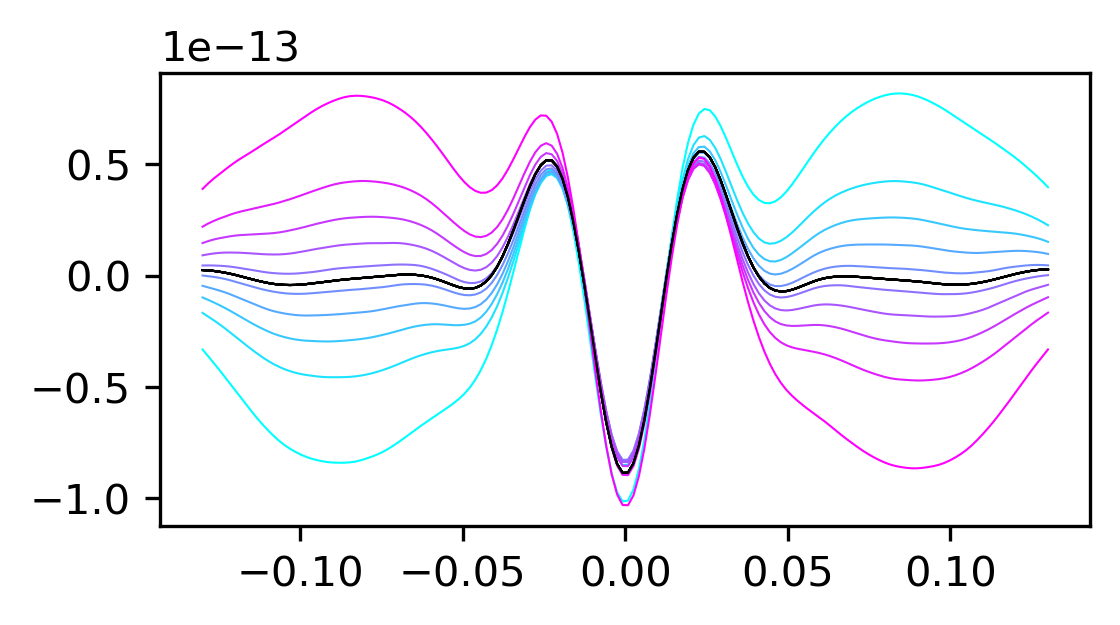

In [13]:
col_r = plt.cm.cool(np.linspace(0,1, num=10))

f, ax = plt.subplots(1, 1, figsize=(4,2), dpi=300, facecolor="white")
for ix, wf in enumerate(wvfrms["PC_1"]):
    ax.plot(waveform_time, wf, lw=0.5, c=col_r[ix])
    ax.plot(waveform_time, mean_waveform, lw=0.5, c="black")

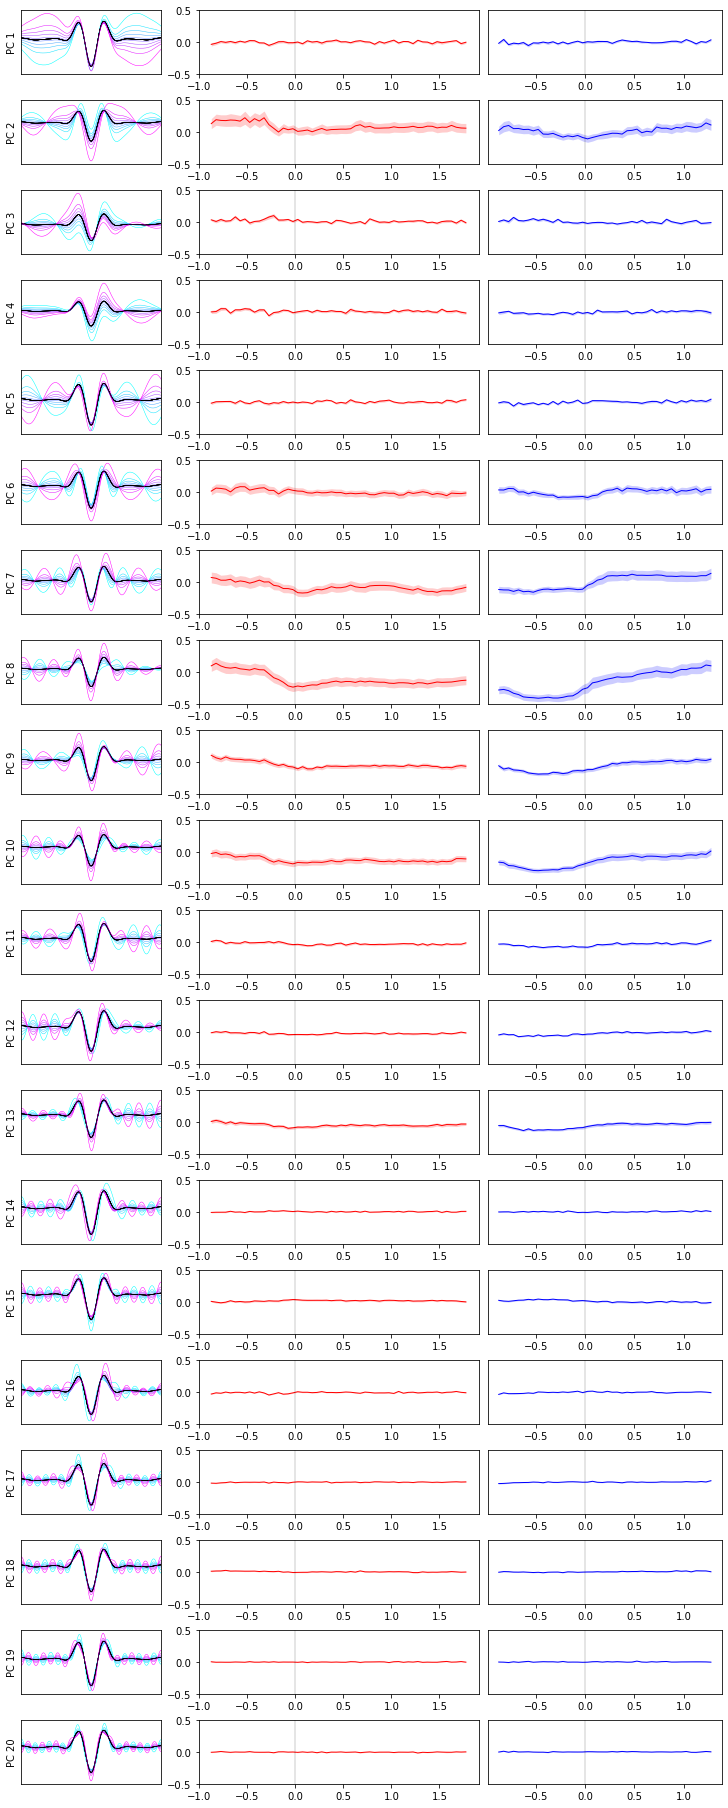

In [48]:
col_r = plt.cm.cool(np.linspace(0,1, num=10))

f, ax = plt.subplots(20, 3, figsize=(10,25), facecolor="white", gridspec_kw={"width_ratios":[1.5, 3, 2.5]}, constrained_layout=True)
for pc_ix in range(20):
    pc_key = "PC_{}".format(pc_ix+1)
    ax[pc_ix, 0].set_ylabel("PC {}".format(pc_ix+1))
    
    for ix, wf in enumerate(wvfrms[pc_key]):
        ax[pc_ix, 0].plot(waveform_time, wf, lw=0.5, c=col_r[ix])
        ax[pc_ix, 0].plot(waveform_time, mean_waveform, lw=0.5, c="black")
    
    vis_mean = np.mean(PC_mean_score_in_time["vis"][pc_key], axis=0)
    mot_mean = np.mean(PC_mean_score_in_time["mot"][pc_key], axis=0)
    vis_sem = np.std(PC_mean_score_in_time["vis"][pc_key], axis=0) / np.sqrt(36)
    mot_sem = np.std(PC_mean_score_in_time["mot"][pc_key], axis=0) / np.sqrt(36)

    ax[pc_ix, 1].plot(vis_time_plot, vis_mean, lw=1, c="red")
    ax[pc_ix, 1].fill_between(
        vis_time_plot, 
        vis_mean - vis_sem,
        vis_mean + vis_sem,
        lw=0, color="red", alpha=0.2
    )
    ax[pc_ix, 1].axvline(0, lw=0.2, color="black")
    
    ax[pc_ix, 2].plot(mot_time_plot, mot_mean, lw=1, c="blue")
    ax[pc_ix, 2].fill_between(
        mot_time_plot, 
        mot_mean - mot_sem,
        mot_mean + mot_sem,
        lw=0, color="blue", alpha=0.2
    )
    ax[pc_ix, 2].axvline(0, lw=0.2, color="black")
    
    ax[pc_ix, 0].set_xticks([])
    ax[pc_ix, 0].set_yticks([])
    ax[pc_ix, 2].set_yticks([])
    ax[pc_ix, 0].set_xlim(-.13, .13)
    ax[pc_ix, 1].set_ylim(-.5, .5)
    ax[pc_ix, 2].set_ylim(-.5, .5)

plt.savefig("/scratch/BURST_PAPER/updated_supplementary_all_PC_score_x_time.svg")

In [15]:
PC_to_analyse = ["PC_7", "PC_8", "PC_9", "PC_10"]

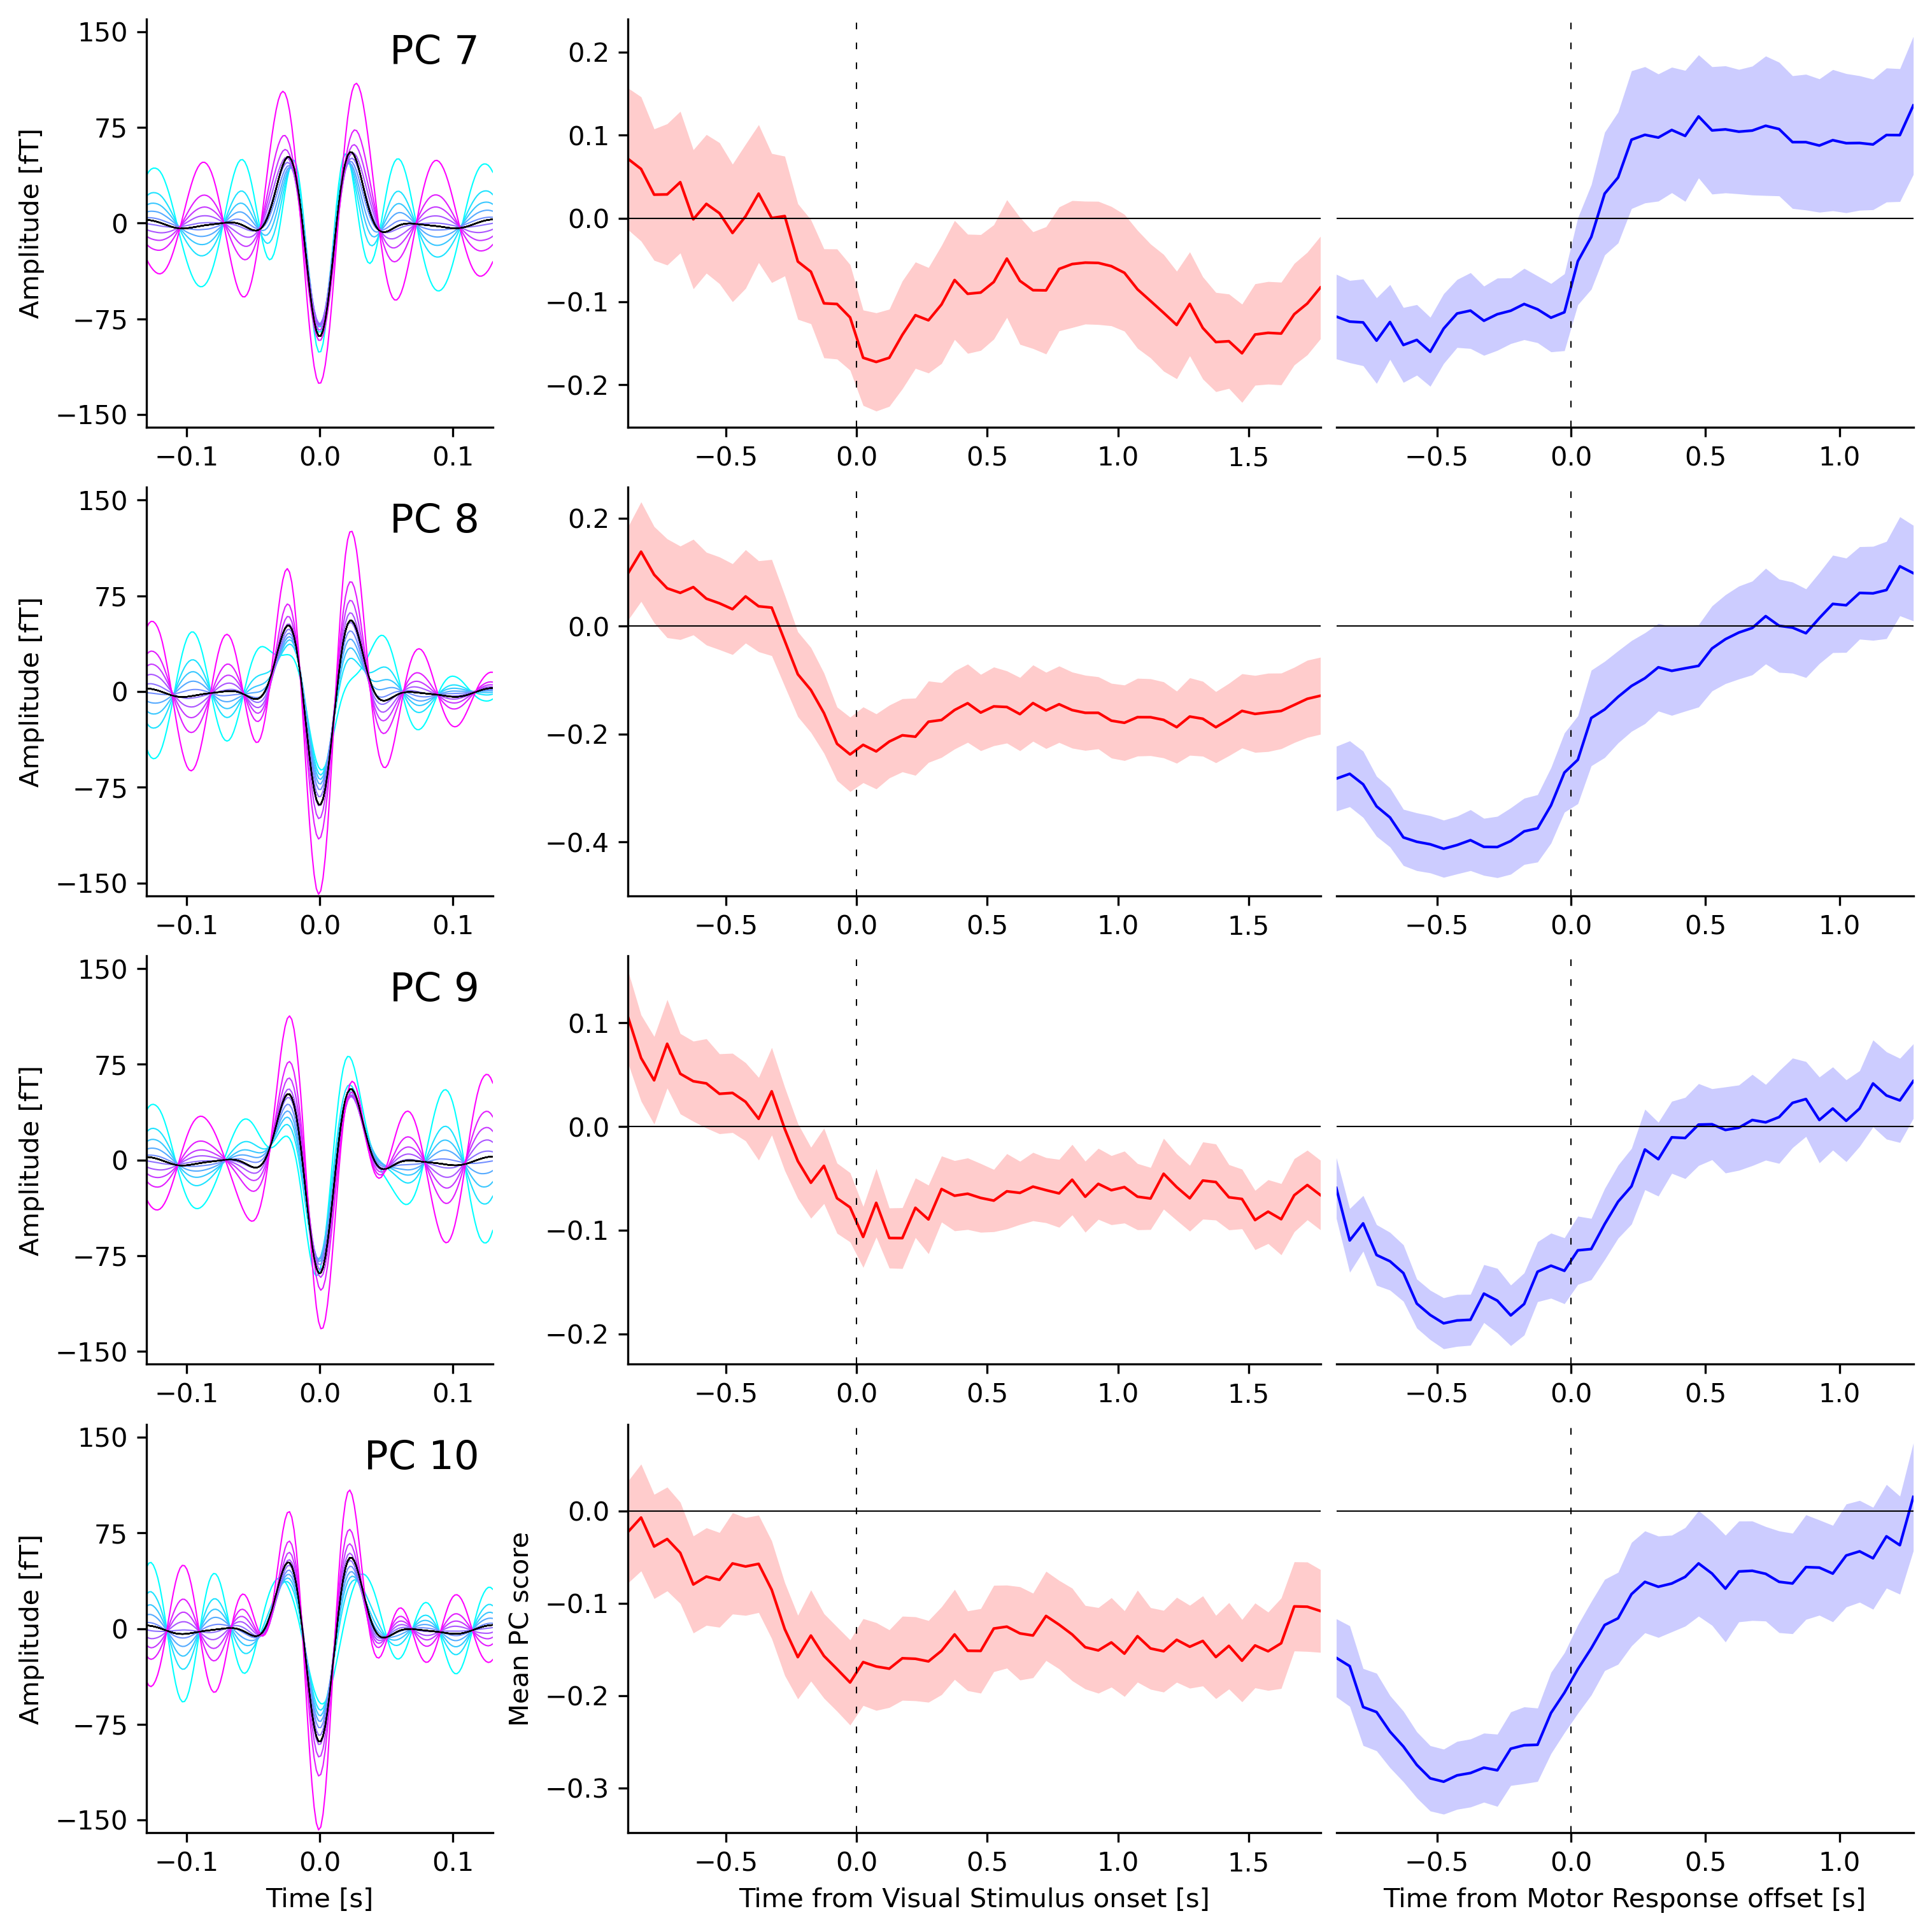

In [28]:
col_r = plt.cm.cool(np.linspace(0,1, num=10))

f, ax = plt.subplots(
    len(PC_to_analyse), 3, figsize=(10,10),
    facecolor="white", 
    gridspec_kw={"width_ratios": [1.5, 3, 2.5]},
    constrained_layout=True, dpi=300
)
for pc_ix, pc_key in enumerate(PC_to_analyse):
    label = " ".join([i for i in pc_key.split("_")])
    ax[pc_ix, 0].annotate(
        label, xy=(0.12, 125), fontsize=15, ha="right"
    )
    
    ax[pc_ix, 0].set_ylabel("Amplitude [fT]")
    
    for ix, wf in enumerate(wvfrms[pc_key]):
        ax[pc_ix, 0].plot(waveform_time, wf / 1e-15, lw=0.5, c=col_r[ix])
        ax[pc_ix, 0].plot(waveform_time, mean_waveform / 1e-15, lw=0.5, c="black")
    
    vis_mean = np.mean(PC_mean_score_in_time["vis"][pc_key], axis=0)
    mot_mean = np.mean(PC_mean_score_in_time["mot"][pc_key], axis=0)
    vis_sem = np.std(PC_mean_score_in_time["vis"][pc_key], axis=0) / np.sqrt(36)
    mot_sem = np.std(PC_mean_score_in_time["mot"][pc_key], axis=0) / np.sqrt(36)

    ax[pc_ix, 1].plot(vis_time_plot, vis_mean, lw=1, c="red")
    ax[pc_ix, 1].fill_between(
        vis_time_plot, 
        vis_mean - vis_sem,
        vis_mean + vis_sem,
        lw=0, color="red", alpha=0.2
    )
    ax[pc_ix, 1].axvline(0, lw=0.5, color="black", linestyle=(0, (5, 10)))
    ax[pc_ix, 1].axhline(0, lw=0.5, color="black")
    
    ax[pc_ix, 2].plot(mot_time_plot, mot_mean, lw=1, c="blue")
    ax[pc_ix, 2].fill_between(
        mot_time_plot, 
        mot_mean - mot_sem,
        mot_mean + mot_sem,
        lw=0, color="blue", alpha=0.2
    )
    ax[pc_ix, 2].axvline(0, lw=0.5, color="black", linestyle=(0, (5, 10)))
    ax[pc_ix, 2].axhline(0, lw=0.5, color="black")
    
    ax[pc_ix, 0].set_xticks([-0.1, 0, 0.1])
    ax[pc_ix, 0].set_yticks([-150, -75, 0, 75, 150])
    ax[pc_ix, 0].set_xlim(-.13, .13)
    ax[pc_ix, 0].set_ylim(-160, 160)
    
    ax[pc_ix, 2].set_yticks([])
    
    
    ax[pc_ix, 1].set_xlim(vis_time_plot[0], vis_time_plot[-1])
    
    ax[pc_ix, 2].set_xlim(mot_time_plot[0], mot_time_plot[-1])
    
    ymin = np.min([ax[pc_ix, 1].get_ylim()[0], ax[pc_ix, 2].get_ylim()[0]])
    ymax = np.max([ax[pc_ix, 1].get_ylim()[1], ax[pc_ix, 2].get_ylim()[1]])
    ax[pc_ix, 1].set_ylim(ymin, ymax)
    ax[pc_ix, 2].set_ylim(ymin, ymax)
    
    for key, spine in ax[pc_ix, 0].spines.items():
        if key in ["top", "right"]:
            spine.set_visible(False)
    
    for key, spine in ax[pc_ix, 1].spines.items():
        if key in ["top", "right"]:
            spine.set_visible(False)
    
    for key, spine in ax[pc_ix, 2].spines.items():
        if key in ["top", "right", "left"]:
            spine.set_visible(False)

ax[3, 0].set_ylabel("Amplitude [fT]")
ax[3, 0].set_xlabel("Time [s]")
ax[3, 1].set_ylabel("Mean PC score")
ax[3, 1].set_xlabel("Time from Visual Stimulus onset [s]")
ax[3, 2].set_xlabel("Time from Motor Response offset [s]")

plt.savefig("/scratch/BURST_PAPER/FIGURE_4_PC_score_x_time.svg")